In [27]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import math

import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, SGDRegressor, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, GridSearchCV, learning_curve, KFold, RandomizedSearchCV, cross_validate
from sklearn.metrics import mean_squared_error, r2_score
from prettytable import PrettyTable

### Loading and Cleaning Data

In [24]:
well_1 = pd.read_csv('123339_RT_edited.csv')

len(well_1)
well_1.head()

,0108_T,0110_T,0112_T,0113_T,0115_T,0117_T,0119_T,0120_T,0121_T,0122_T,...,0124_T,0128_T,0130_T,0140_T,0141_T,0170_T,0171_T,0713_T,0715_T,0824_T
0,10704.0498,10704.0498,105.68,118.9,211.7,12.3,13322,59,2950,34,...,49,8,304,126,25.3,126,749,1.87,86.31,124
1,10704.0596,10704.0596,163.58,127.6,183.9,15.0,9970,40,3883,37,...,53,12,329,861,-4.0,861,697,83.06,1.32,124
2,10704.0703,11810.0000,117.53,0.0,213.1,0.0,5,0,30,40,...,0,0,0,4,0.0,4,-2182,3.14,60.84,96
3,10704.1201,10704.1201,105.61,118.9,211.6,12.8,13322,59,2949,35,...,49,7,304,126,25.3,126,751,1.87,86.31,124
4,10704.1299,10704.1299,163.46,125.3,183.8,15.3,10159,40,3890,37,...,53,13,329,861,-4.0,861,703,83.06,1.32,124


In [25]:
lp = 10704
well_1 = well_1[(well_1["0108_T"]==well_1["0110_T"]) & (well_1["0108_T"]>=lp) & (well_1['0113_T']>0) & (well_1['0120_T']>=50)]
print(len(well_1))

well_1.columns = ['bit_depth', 'hole_depth', 'block_height', 'ROP', 'hook_load', 'weight_on_bit',
                  'rotary_torque', 'rotary_speed', 'pump_pressure', 'casing_press', 'pump_1_rate', 'pump_2_rate',
                  'flow_out', 'pump_output', 'gas_3rd_party', 'mse', 'gas', 'diff_pres', 'inclination', 'azimuth',
                  'gamma']
well_df = well_1.drop(columns='hole_depth')
well_df.rename(columns={'bit_depth':'depth'}, inplace=True)

well_df.head() 

102023


,depth,block_height,ROP,hook_load,weight_on_bit,rotary_torque,rotary_speed,pump_pressure,casing_press,pump_1_rate,pump_2_rate,flow_out,pump_output,gas_3rd_party,mse,gas,diff_pres,inclination,azimuth,gamma
0,10704.0498,105.68,118.9,211.7,12.3,13322,59,2950,34,49,49,8,304,126,25.3,126,749,1.87,86.31,124
3,10704.1201,105.61,118.9,211.6,12.8,13322,59,2949,35,49,49,7,304,126,25.3,126,751,1.87,86.31,124
5,10704.1904,105.54,119.0,211.5,13.0,13017,60,2955,35,49,49,9,304,126,25.4,126,763,1.87,86.31,124
7,10704.2598,105.47,121.1,211.4,12.9,12525,61,2968,35,49,49,7,304,126,24.6,126,774,1.87,86.31,124
10,10704.3398,105.40,119.7,211.5,12.8,13027,60,2963,35,49,49,7,304,126,24.2,126,763,1.87,86.31,124


### Exploratory Data Analysis

In [11]:
well_df.describe()

,depth,block_height,ROP,hook_load,weight_on_bit,rotary_torque,rotary_speed,pump_pressure,casing_press,pump_1_rate,pump_2_rate,flow_out,pump_output,gas_3rd_party,mse,gas,diff_pres,inclination,azimuth,gamma
count,102023.000000,102023.000000,102023.000000,102023.000000,102023.000000,102023.000000,102023.000000,102023.000000,102023.000000,102023.000000,102023.000000,102023.000000,102023.000000,102023.000000,102023.000000,102023.000000,102023.000000,102023.000000,102023.000000,102023.000000
mean,16381.023105,186.151495,179.093177,167.057292,24.269287,11607.126785,59.363849,4363.295326,35.986327,50.619684,52.294316,9.951629,326.417131,1227.357900,22.318096,1228.200955,605.600531,19.495025,176.890020,130.095390
std,3051.785681,34.419586,98.939070,19.160435,12.282114,4436.154345,1.491951,561.098256,108.860406,126.020754,117.922451,132.965031,148.391188,635.350435,98.169696,627.554119,332.702197,807.499247,836.341267,142.701153
min,10704.049800,87.810000,9.700000,113.800000,0.000000,688.000000,50.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-934.000000,-9999.000000,-9999.000000,-9999.000000
25%,13859.260250,159.040000,55.300000,157.800000,16.500000,10127.000000,59.000000,4132.000000,36.000000,53.000000,53.000000,11.000000,329.000000,769.000000,11.300000,769.000000,270.000000,89.690000,2.260000,124.000000
50%,16843.130900,189.040000,224.700000,167.400000,21.600000,12669.000000,60.000000,4434.000000,37.000000,53.000000,53.000000,12.000000,329.000000,1212.000000,14.600000,1212.000000,787.000000,90.470000,357.090000,131.000000
75%,19039.459950,215.170000,256.600000,174.900000,27.600000,14517.000000,60.000000,4779.000000,39.000000,53.000000,53.000000,13.000000,329.000000,1664.000000,20.500000,1664.000000,868.000000,91.290000,358.660000,142.000000
max,20931.039100,251.390000,699.100000,239.300000,70.300000,20596.000000,64.000000,5167.000000,44.000000,57.000000,106.000000,25.000000,353.000000,2989.000000,3602.000000,2989.000000,973.000000,94.740000,359.980000,315.000000


In [20]:
well_df.isnull().sum()
well_df.corr()

,depth,block_height,ROP,hook_load,weight_on_bit,rotary_torque,rotary_speed,pump_pressure,casing_press,pump_1_rate,pump_2_rate,flow_out,pump_output,gas_3rd_party,mse,gas,diff_pres,inclination,azimuth,gamma
depth,1.000000,0.524636,-0.201426,-0.655749,0.383668,0.074830,-0.044162,0.573014,-0.006140,0.006631,-0.000159,0.000637,0.024991,0.376201,0.064267,0.381286,-0.289230,0.120361,0.144967,0.068922
block_height,0.524636,1.000000,-0.209882,-0.400437,0.133670,-0.145675,-0.123433,0.212670,-0.007489,0.001163,-0.001551,-0.001916,0.016109,0.046362,0.036077,0.046591,-0.377741,0.061933,0.088934,0.043460
ROP,-0.201426,-0.209882,1.000000,0.258111,-0.506468,0.746908,0.418265,0.454891,-0.004537,-0.007381,-0.001318,-0.003026,-0.007043,-0.080222,-0.157147,-0.080384,0.855724,-0.030661,-0.042663,-0.005850
hook_load,-0.655749,-0.400437,0.258111,1.000000,-0.821811,0.324753,0.267892,-0.533728,-0.000076,-0.012409,-0.007092,-0.007458,-0.045035,-0.396461,-0.044659,-0.401969,0.395928,-0.068401,-0.092126,-0.051517
weight_on_bit,0.383668,0.133670,-0.506468,-0.821811,1.000000,-0.482341,-0.367998,0.125998,0.005768,0.011396,0.004984,0.007562,0.030622,0.211937,0.086029,0.215060,-0.541364,0.045623,0.052267,0.026226
rotary_torque,0.074830,-0.145675,0.746908,0.324753,-0.482341,1.000000,0.431446,0.364185,-0.004401,-0.007778,-0.005946,-0.005783,-0.017729,-0.131213,-0.053070,-0.131874,0.718139,-0.001823,-0.018016,0.006741
rotary_speed,-0.044162,-0.123433,0.418265,0.267892,-0.367998,0.431446,1.000000,0.156109,-0.001399,-0.004695,-0.001350,-0.002401,-0.010973,-0.063968,-0.061221,-0.064424,0.410305,0.291582,0.272358,0.068276
pump_pressure,0.573014,0.212670,0.454891,-0.533728,0.125998,0.364185,0.156109,1.000000,0.273749,0.285948,0.306662,0.268714,0.278675,0.404512,0.102452,0.383164,0.360324,0.042531,0.054724,0.043619
casing_press,-0.006140,-0.007489,-0.004537,-0.000076,0.005768,-0.004401,-0.001399,0.273749,1.000000,0.864574,0.924488,0.816375,0.754478,0.088470,0.553827,-0.006780,-0.005957,-0.001592,-0.002970,-0.000311
pump_1_rate,0.006631,0.001163,-0.007381,-0.012409,0.011396,-0.007778,-0.004695,0.285948,0.864574,1.000000,0.930451,0.941604,0.870948,0.088195,0.479915,0.005953,-0.008700,-0.001352,0.000404,0.000583


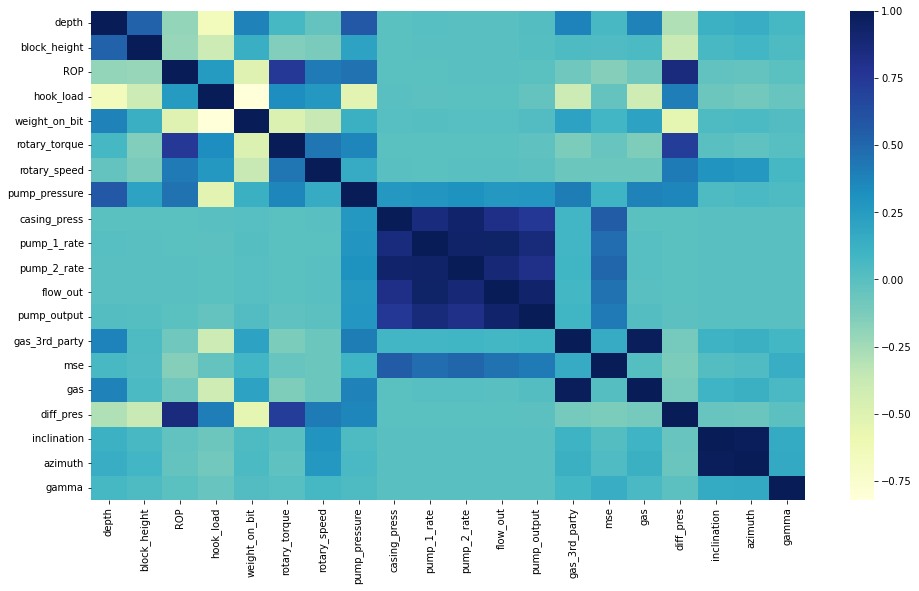

In [17]:
plt.figure(figsize=(16,9))
sns.heatmap(well_df.corr(), cmap='YlGnBu')
plt.show()

From the correlation table/heatmap, 'differential pressure' and 'rotary torque' are observed to be strongly correlated to 'rate of penetration' while 'weight on bit' appears to be inversely correlated.

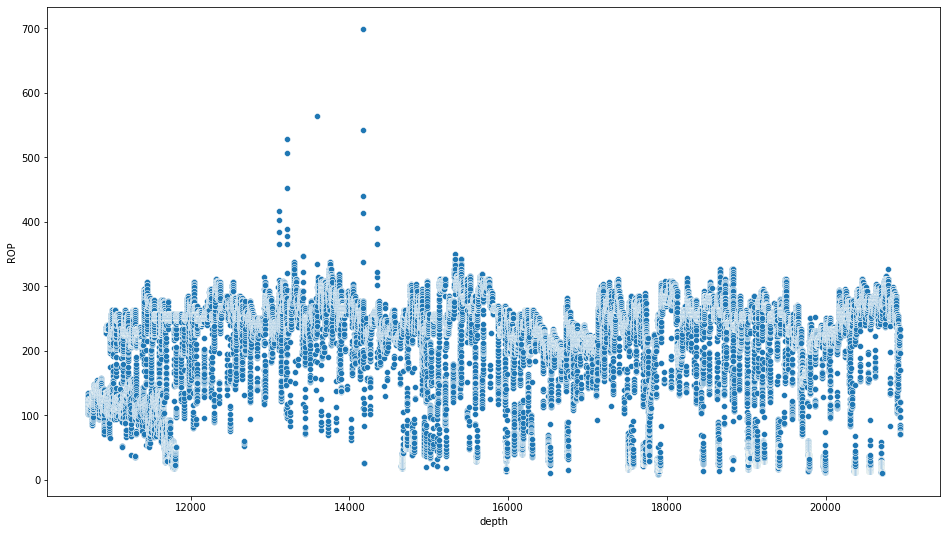

In [19]:
fig, ax=plt.subplots(figsize=(16,9))
sns.scatterplot(data=well_df, x='depth', y='ROP')
plt.show()

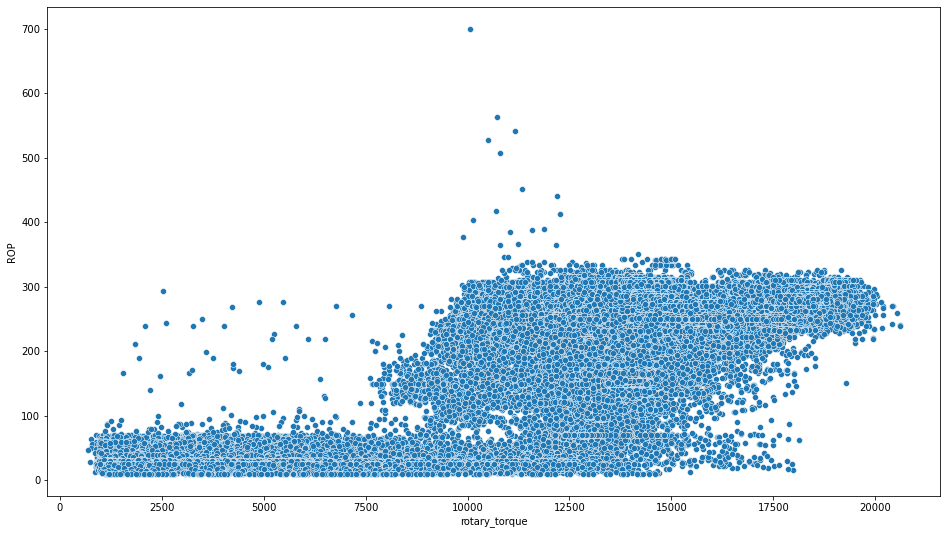

In [22]:
fig, ax=plt.subplots(figsize=(16,9))
sns.scatterplot(data=well_df, x='rotary_torque', y='ROP')
plt.show()

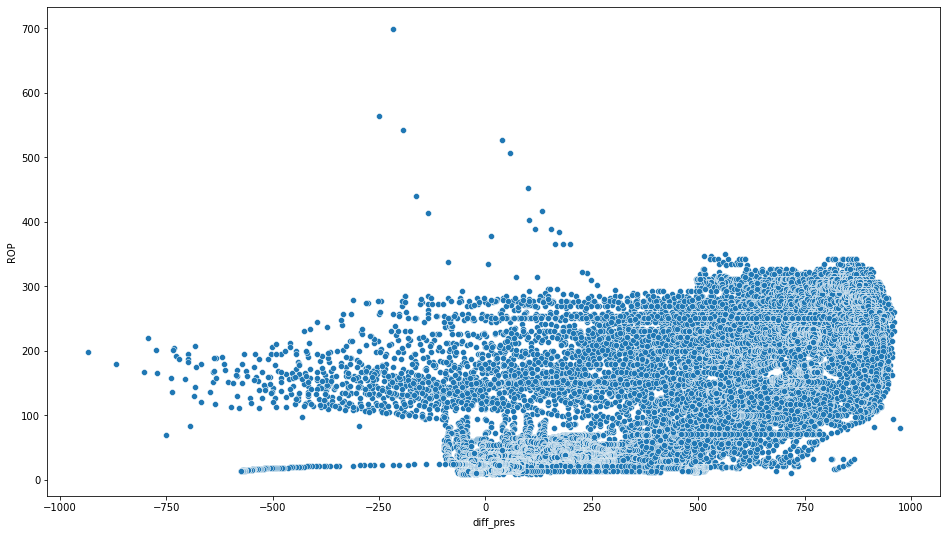

In [21]:
fig, ax=plt.subplots(figsize=(16,9))
sns.scatterplot(data=well_df, x='diff_pres', y='ROP')
plt.show()

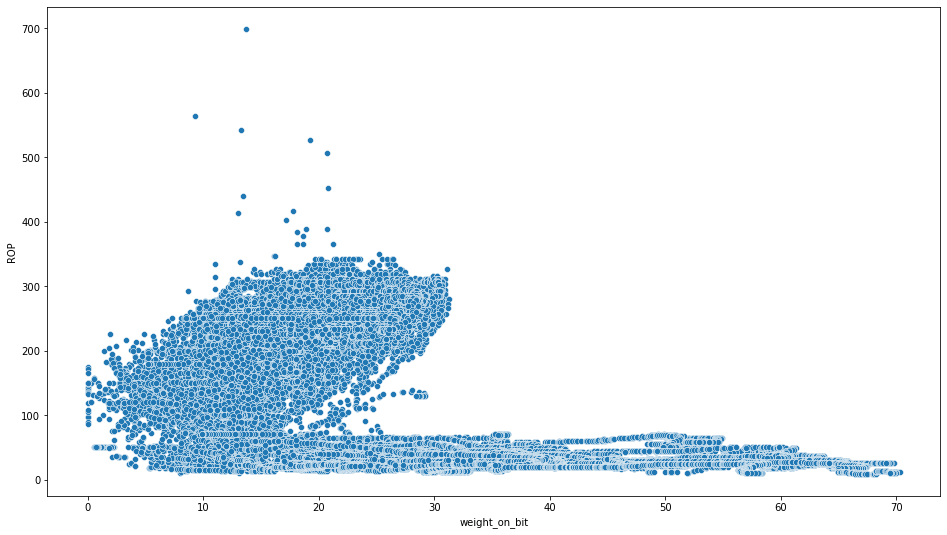

In [26]:
fig, ax=plt.subplots(figsize=(16,9))
sns.scatterplot(data=well_df, x='weight_on_bit', y='ROP')
plt.show()

### Model Fitting

#### Multiple Linear Regression

In [30]:
well_scaled = well_df.copy()
X = well_scaled.drop(columns='ROP')
y = well_scaled['ROP'].values

scaler = StandardScaler()
X = scaler.fit_transform(X)

X1 = pd.DataFrame(X)
feature_matrix = sm.add_constant(X1, prepend=False)
model = sm.OLS(y, feature_matrix)
reg = model.fit()
reg.summary()

/Users/ajoseph/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.884
Model:                            OLS   Adj. R-squared:                  0.884
Method:                 Least Squares   F-statistic:                 4.075e+04
Date:                Sun, 29 May 2022   Prob (F-statistic):               0.00
Time:                        06:31:09   Log-Likelihood:            -5.0380e+05
No. Observations:              102023   AIC:                         1.008e+06
Df Residuals:                  102003   BIC:                         1.008e+06
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0            -49.3786      0.223   -221.189      0.000     -49.816     -48.941
1              1.5942      0.155     10.269      0.000       1.290       1.898
2            -38.6356      0.468    -82.539      0.000     -39.553     -37.718
3            -31.1683      0.318    -97.946      0.000     -31.792     -30.545
4             45.3274      0.198    229.040      0.000      44.940      45.715
5              3.3042      0.129     25.534      0.000       3.051       3.558
6             35.6775      0.373     95.729      0.000      34.947      36.408
7              0.1786      0.289      0.617      0.537      -0.389       0.746
8             -1.1539      0.407     -2.836      0.005      -1.951      -0.356
9            -10.3138      0.398    -25.889      0.000     -11.095      -9.533
10             1.5732      0.406      3.871      0.000       0.777       2.370
11            -0.9058      0.279     -3.243      0.001      -1.453      -0.358
12           137.1024      1.728     79.327      0.000     133.715     140.490
13           -24.0690      0.263    -91.459      0.000     -24.585     -23.553
14          -138.6123      1.706    -81.247      0.000    -141.956    -135.268
15            19.3575      0.279     69.295      0.000      18.810      19.905
16             3.7739      0.575      6.564      0.000       2.647       4.901
17            -3.0827      0.576     -5.353      0.000      -4.212      -1.954
18            -0.1908      0.110     -1.739      0.082      -0.406       0.024
const        179.0932      0.106   1694.522      0.000     178.886     179.300
==============================================================================
Omnibus:                    35018.191   Durbin-Watson:                   0.311
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          3269857.707
Skew:                           0.708   Prob(JB):                         0.00
Kurtosis:                      30.698   Cond. No.                         51.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The R2 value is 0.884 which means the input variables do explain a good amount of the overall variance in the 'rate of penetration' output variable. We need to observe a plot of the observed data on the fitted line in order to truly understand whether the model is correctly specified.

In [33]:
feat = {}
c = 0
for col in well_df.drop(columns='ROP').columns:
    feat[c] = col
    c+=1
print(feat)
reg.pvalues

{0: 'depth', 1: 'block_height', 2: 'hook_load', 3: 'weight_on_bit', 4: 'rotary_torque', 5: 'rotary_speed', 6: 'pump_pressure', 7: 'casing_press', 8: 'pump_1_rate', 9: 'pump_2_rate', 10: 'flow_out', 11: 'pump_output', 12: 'gas_3rd_party', 13: 'mse', 14: 'gas', 15: 'diff_pres', 16: 'inclination', 17: 'azimuth', 18: 'gamma'}


0         0.000000e+00
1         9.990224e-25
2         0.000000e+00
3         0.000000e+00
4         0.000000e+00
5        2.359051e-143
6         0.000000e+00
7         5.372968e-01
8         4.568839e-03
9        2.654691e-147
10        1.083011e-04
11        1.183603e-03
12        0.000000e+00
13        0.000000e+00
14        0.000000e+00
15        0.000000e+00
16        5.249674e-11
17        8.681835e-08
18        8.199278e-02
const     0.000000e+00
dtype: float64

According to the p-values, all the predictors except 'casing pressure' are individually significant predictors of rate of penetration since the p-values are below 0.5.

Despite the fact that many of the predictors exhibit small p-values suggesting individual significance, the weight attached to the 'gas 3rd party' parameter has the largest coefficient value at about 137.1 which suggests that it is the best predictor of 'ROP'.

0.7080614810458538


/Users/ajoseph/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


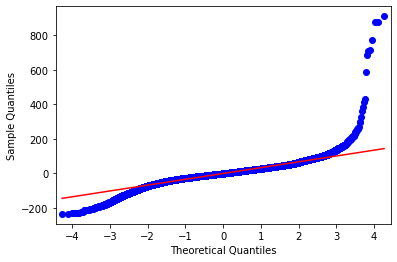

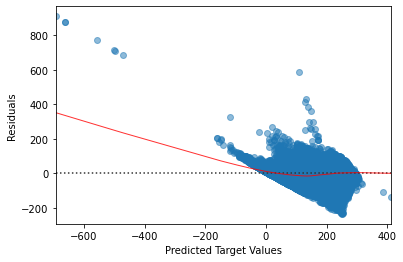

In [34]:
print(reg.resid.skew())
fig = sm.qqplot(reg.resid, line="s")
plt.show()

y_pred = reg.predict(feature_matrix)
                     
hom = sns.residplot(x=y_pred,y=reg.resid,lowess=True,scatter_kws={'alpha': 0.5},
                    line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8},)
                              
                              
# hom.map(sns.scatterplot, alpha=0.2)
plt.xlabel('Predicted Target Values')
plt.ylabel('Residuals')
plt.show()

# HERE Need to add about assumptions of normality and homogeneity of variance for the regression model.

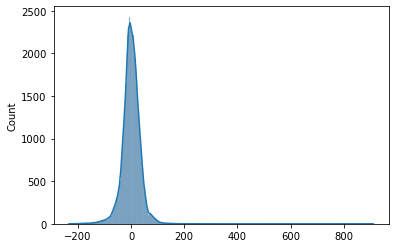

In [35]:
sns.histplot(reg.resid, kde=True)
plt.show()

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(68355, 19)
(33668, 19)
(68355,)
(33668,)


The histogram of the residuals appears to be normally distributed, therefore verifying the normality assumption.

In [37]:
lr = LinearRegression()
lr_r2 = cross_val_score(lr, X_train, y_train, scoring="r2", cv=10)
lr_mse = cross_val_score(lr, X_train, y_train, scoring="neg_mean_squared_error", cv=10)  
lr_rmse = np.sqrt(-lr_mse) 

results_table = PrettyTable()
results_table.field_names = ['Regressor', 'R2', 'RMSE', 'MSE']

results_table.add_row(['Linear Regression', format(lr_r2.mean(), '.4f'), format(lr_rmse.mean(), '.4f'), format(lr_mse.mean(),'.4f')])   
print(results_table)

+-------------------+--------+---------+------------+
|     Regressor     |   R2   |   RMSE  |    MSE     |
+-------------------+--------+---------+------------+
| Linear Regression | 0.8845 | 33.5951 | -1130.6210 |
+-------------------+--------+---------+------------+


In [38]:
seed = 0
models = []
models.append(('Decision Tree', DecisionTreeRegressor(random_state=seed)))
models.append(('Random Forest', RandomForestRegressor(random_state=seed, n_estimators=30)))
models.append(('SGD', SGDRegressor(max_iter=1000, tol=1e-3)))
models.append(('Lasso', Lasso(alpha=0.1)))
models.append(('ElasticNet', ElasticNet(random_state=seed)))
models.append(('Ridge', Ridge(alpha=0.5)))
models.append(('Bagging', BaggingRegressor(DecisionTreeRegressor(random_state=seed), n_estimators=500, n_jobs=-1, bootstrap=True, random_state=42)))


results_table = PrettyTable()
results_table.field_names = ['Regressor', 'R2', 'RMSE', 'MSE']

for model in models:
    model[1].fit(X_train, y_train)
    y_pred = model[1].predict(X_test)
    r2 = r2_score(y_test,y_pred)
    mse=mean_squared_error(y_test,y_pred)
    results_table.add_row([model[0], format(r2, '.4f'), format(np.sqrt(mse), '.4f'), format(mse,'.4f')])   
print(results_table)

/Users/ajoseph/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.063e+06, tolerance: 6.696e+04
  model = cd_fast.enet_coordinate_descent(


+---------------+-------------------------+------------------+----------------------------+
|   Regressor   |            R2           |       RMSE       |            MSE             |
+---------------+-------------------------+------------------+----------------------------+
| Decision Tree |          0.9891         |     10.3306      |          106.7213          |
| Random Forest |          0.9940         |      7.6291      |          58.2029           |
|      SGD      | -48608219199018784.0000 | 21796375056.7496 | 475081965614496874496.0000 |
|     Lasso     |          0.8809         |     34.1141      |         1163.7692          |
|   ElasticNet  |          0.8022         |     43.9633      |         1932.7728          |
|     Ridge     |          0.8761         |     34.8011      |         1211.1133          |
|    Bagging    |          0.9943         |      7.4453      |          55.4322           |
+---------------+-------------------------+------------------+------------------